#调用GPU

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


#创建虚拟GPU（Tensorflow）

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Create 2 virtual GPUs with 1GB memory each
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024),
         tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPU, 2 Logical GPUs


In [4]:
tf.debugging.set_log_device_placement(True)

#下载pytorch

In [5]:
!pip3 install torch torchvision torchaudio

In [6]:
!pip install d2l==0.14

     |████████████████████████████████| 48 kB 2.6 MB/s 


#多GPU数据并行的实现

In [7]:
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [8]:
#初始化模型参数
scale = 0.01
W1 = torch.randn(size=(20,1,3,3))*scale
b1 = torch.zeros(20)
W2 = torch.randn(size=(50,20,5,5))*scale
b2 = torch.zeros(50)
W3 = torch.randn(size=(800,128))*scale
b3 = torch.zeros(128)
W4 = torch.randn(size=(128,10))*scale
b4 = torch.zeros(10)
params = [W1,b1,W2,b2,W3,b3,W4,b4]

#定义LeNet模型
def lenet(X,params):
    h1_conv = F.conv2d(input=X,weight=params[0],bias=params[1])
    h1_activation = F.relu(h1_conv)
    h1 = F.avg_pool2d(input=h1_activation,kernel_size=(2,2),stride=(2,2))
    h2_conv = F.conv2d(input=h1,weight=params[2],bias=params[3])
    h2_activation = F.relu(h2_conv)
    h2 = F.avg_pool2d(input=h2_activation,kernel_size=(2,2),stride=(2,2))
    h2 = h2.reshape(h2.shape[0],-1)
    h3_linear = torch.mm(h2,params[4]) + params[5]
    h3 = F.relu(h3_linear)
    y_hat = torch.mm(h3,params[6])+params[7]
    return y_hat

#交叉熵损失函数
loss = nn.CrossEntropyLoss(reduction='none')

In [9]:
#确定CPU还是GPU训练，定义梯度下降
def get_params(params,device):
    new_params = [p.to(device) for p in params]
    for p in new_params:
        p.requires_grad_()
    return new_params

In [10]:
new_params = get_params(params,d2l.try_gpu(0))
print('b1 weight:',new_params[1])
print('b1 grad:',new_params[1].grad)

b1 weight: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', requires_grad=True)
b1 grad: None


In [11]:
#数据累积和数据复制
def allreduce(data):
    for i in range(1,len(data)):
        data[0][:] += data[i].to(data[0].device)
    for i in range(1,len(data)):
        data[i][:] = data[0].to(data[i].device)

In [12]:
data = [torch.ones((1,2),device=d2l.try_gpu(i))*(i+1) for i in range(2)]
print('allreduce before: \n',data[0],'\n',data[1])
allreduce(data)
print('allreduce after: \n',data[0],'\n',data[1])

allreduce before: 
 tensor([[1., 1.]], device='cuda:0') 
 tensor([[2., 2.]])
allreduce after: 
 tensor([[3., 3.]], device='cuda:0') 
 tensor([[3., 3.]])


In [13]:
data = torch.arange(20).reshape(4,5)
devices = tf.config.list_logical_devices('GPU')
split = nn.parallel.scatter(data,devices)
print('input:',data)
print('load into',devices)
print('output:',split)

input: tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]])
load into [LogicalDevice(name='/device:GPU:0', device_type='GPU'), LogicalDevice(name='/device:GPU:1', device_type='GPU')]
output: (tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]], device='cuda:0'), tensor([[10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]], device='cuda:0'))


In [14]:
#将数据分配到各个GPU上
def split_batch(X,y,devices):
    """将x和y拆分到多个设备上"""
    assert X.shape[0] == y.shape[0]
    return (nn.parallel.scatter(X,devices),
            nn.parallel.scatter(y,devices))

In [15]:
#小批量训练
def train_batch(X,y,device_params,devices,lr):
    X_shards,y_shards = split_batch(X,y,devices)
    #在每个GPU上分别计算损失
    ls = [loss(lenet(X_shard,device_W),y_shard).sum() for X_shard,y_shard ,device_W in zip(X_shards,y_shards,device_params)]
    for l in ls:  #反向传播在每个GPU上分别执行
        l.backward()
    #将每个GPU的所有梯度相加，并将其广播到所有GPU
    with torch.no_grad():
        for i in range(len(device_params[0])):
            allreduce([device_params[c][i].grad for c in range(len(devices))])
    #在每个GPU上分别更新模型参数
    for param in device_params:
        d2l.sgd(param,lr,X.shape[0]) # 使用全尺寸的小批量

In [18]:
#训练函数
def train(num_gpus,batch_size,lr):
    train_iter,test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    #将模型参数复制到num_gpus个GPU
    device_params = [get_params(params,d) for d in devices]
    num_epochs = 10
    animator = d2l.Animator('epoch','test acc',xlim=[1,num_epochs])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        timer.start()
        for X,y in train_iter:
            #为单个小批量执行多GPU训练
            train_batch(X,y,device_params,devices,lr)
            torch.cuda.synchronize()
        timer.stop()
        #在GPU0上评估模型
        animator.add(epoch+1,(d2l.evaluate_accuracy_gpu(lambda x: lenet(x,device_params[0]),test_iter,devices[0]),))
    print(f'test acc:{animator.Y[0][-1]:.2f},{timer.avg():.1f}s/round,'
          f'at{str(devices)}')

test acc:0.83,9.5s/round,at[device(type='cuda', index=0)]


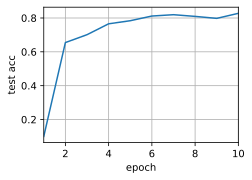

In [19]:
train(num_gpus=1,batch_size=256,lr=0.2)

#利用pytorch框架实现

In [21]:
import torch
from torch import nn
from d2l import torch as d2l

In [26]:
#搭建ResNet18模型
def resnet18(num_classes,in_channels=1):
    """经过修改的ResNet18模型"""
    def resnet_block(in_channels,out_channels,num_residuals,first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(d2l.Residual(in_channels,out_channels,use_1x1conv=True,strides=2))
            else:
                blk.append(d2l.Residual(out_channels,out_channels))
        return nn.Sequential(*blk)

    #该模型使用了更小的卷积核、步长和填充，而且删除了最大汇聚层
    net = nn.Sequential(
        nn.Conv2d(in_channels,64,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU())
    net.add_module("resnet_block1",resnet_block(64,64,2,first_block=True))
    net.add_module("resnet_block2",resnet_block(64,128,2))
    net.add_module("resnet_block3",resnet_block(128,256,2))
    net.add_module("resnet_block4",resnet_block(256,512,2))
    net.add_module("global_avg_pool",nn.AdaptiveAvgPool2d((1,1)))
    net.add_module("fc",nn.Sequential(nn.Flatten(),nn.Linear(512,num_classes)))
    return net

In [27]:
net = resnet18(10)
#获得GPU列表
devices = d2l.try_all_gpus()

In [28]:
def train(net,num_gpus,batch_size,lr):
    train_iter,test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    #初始化网络
    def init_weights(m):
        if type(m) in [nn.Linear,nn.Conv2d]:
            nn.init.normal_(m.weight,std=0.01)
    net.apply(init_weights)
    #在多个GPU上设置模型
    net = nn.DataParallel(net,device_ids=devices)
    trainer = torch.optim.SGD(net.parameters(),lr)
    loss = nn.CrossEntropyLoss()
    timer,num_epochs = d2l.Timer(),10
    animator = d2l.Animator('epoch','test acc',xlim=[1,num_epochs])
    for epoch in range(num_epochs):
        net.train()
        timer.start()
        for X,y in train_iter:
            trainer.zero_grad()
            X,y = X.to(devices[0]),y.to(devices[0])
            l = loss(net(X),y)
            l.backward()
            trainer.step()
        timer.stop()
        animator.add(epoch+1,(d2l.evaluate_accuracy_gpu(net,test_iter),))
    print(f'test acc:{animator.Y[0][-1]:.2f},{timer.avg():.1f}s/round,'
          f'at{str(devices)}')

test acc:0.89,88.5s/round,at[device(type='cuda', index=0)]


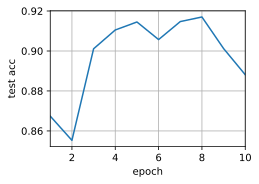

In [29]:
train(net,num_gpus=1,batch_size=256,lr=0.1)